In [ ]:
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [1]:
import pandas as pd 
import cv2, numpy as np
from scipy.stats import norm
from scipy.misc import imread
import re
import pickle
import sys
import idx2numpy as idx
from copy import copy
import os
from datetime import datetime 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# keras
np.random.seed(666)
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics

# logging
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [151]:
rootpath = "../EgyptianHieroglyphDataset/MyTrainTest"
# total_train_n = 21888 # 15488
batch_size = 32 * 2
        # TODO 32 is standard
        # decrease futher for small datasets, e.g. 32 // 2
        # increase if want estimates more stable
        # must be divisible by num training rows, must be int and not float
original_dim = (75, 50) # without convolutional layers, use 75 * 50
myinitializer = "he_normal" 
        # default is "glorot_uniform" aka Xavier's initializer
        # TODO tried he_normal but not sure if this is helpful; change it back to default?
conv1_filter = 8 
conv2_filter = 64 
conv3_filter = 64 
conv4_filter = 128 
conv5_filter = 256 
window_size = 3
intermediate_dim = 32 
latent_dim = 8 # had it at 170 but Andrew didn't recommend it
epochs = 50 # 50
clf_epochs = 3 # 100
lr = 1 * 1e-5 # 0.001
clf_lr = 1 * 1e-6 # 0.001
epsilon_std = 1.0

In [ ]:
def get_data(tr_ts):
    """
    tr_ts: train or test as a string
    """
    if tr_ts == "train":
        try:
            x_train = np.load("../data/x_train.pkl")
            y_train = np.load("../data/y_train.pkl")
        except:
            logging.info("Pickle files not found. Creating data from png files.")
            x_train, y_train = get_tr_array_from_png()
            x_train.dump("../data/x_train.pkl")
            y_train.dump("../data/y_train.pkl")
        return x_train, y_train
    else:
        try:
            x_test = np.load("../data/x_test.pkl")
            y_test = np.load("../data/y_test.pkl")
        except:
            logging.info("Pickle files not found. Creating data from png files.")
            x_test, y_test = get_ts_array_from_png()
            x_test.dump("../data/x_test.pkl")
            y_test.dump("../data/y_test.pkl")
        return x_test, y_test          

In [ ]:
def get_tr_array_from_png():
    """
    data description:
        Dataset is compiled by Morris Franken, complementary to the paper titeled "Automatic Egyptian \
        Hieroglyph Recognition by Retrieving Images as Texts" (ACM Conference on Multimedia, 2013).
    Shape of png file as rgb array:  (75, 50, 3)
    future work: too many caveats to fit model to generator for now; need to try and fix it
    """
    n_symbols = symbol_df.shape[0]
    batch_arrayfile = np.empty((0, 1) + (original_dim))
    batch_label = np.empty((0, n_symbols))
    tr_rootpath = os.path.join(rootpath, "train")
    subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
    print(len(subdirs))
    counter = 0
    for subdirpath in subdirs:
        print(counter, subdirpath)
        subdir = os.path.join(tr_rootpath, subdirpath)
        files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
        for fpath in files:        
            pngfile = os.path.join(subdir, fpath)
            
            # get y
            label_txt = re.sub(r"^.*_(?P<symbol>.*)\.png$", "\g<symbol>", pngfile)
            cond = symbol_df["symbol"] == label_txt
            label_num = int(symbol_df.loc[cond, "symbol_num"])
            label = np_utils.to_categorical(label_num, n_symbols)
            batch_label = np.vstack([batch_label, label])  
            
            # get x
            arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
            arrayfile = np.reshape(arrayfile, (1, 1) + (original_dim)) / 255.
                    # no necessary to / 255. unless working with pre-trained data
                    # without convolutional layers, use np.reshape(arrayfile, original_dim) / 255.
                    # with all 3 layers of rgb, use (1, 3) + (original_dim)
            batch_arrayfile = np.vstack([batch_arrayfile, arrayfile])
        counter += 1
    return batch_arrayfile, batch_label

In [ ]:
def get_ts_array_from_png():
    """
    data description:
        Dataset is compiled by Morris Franken, complementary to the paper titeled "Automatic Egyptian \
        Hieroglyph Recognition by Retrieving Images as Texts" (ACM Conference on Multimedia, 2013).
    Shape of png file as rgb array:  (75, 50, 3)
    future work: too many caveats to fit model to generator for now; need to try and fix it
    """
    n_symbols = symbol_df.shape[0]
    batch_arrayfile = np.empty((0, 1) + (original_dim))
    batch_label = np.empty((0, n_symbols))
    ts_rootpath = os.path.join(rootpath, "test")
    files = [x for x in os.listdir(ts_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:
        pngfile = os.path.join(ts_rootpath, fpath)
            
        # get y
        label_txt = re.sub(r"^.*_(?P<symbol>.*)\.png$", "\g<symbol>", pngfile)
        try:
            cond = symbol_df["symbol"] == label_txt
            label_num = int(symbol_df.loc[cond, "symbol_num"])
            label = np_utils.to_categorical(label_num, n_symbols)
            batch_label = np.vstack([batch_label, label])
            
            # get x
            arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
            arrayfile = np.reshape(arrayfile, (1, 1) + (original_dim)) / 255.
                    # no necessary to / 255. unless working with pre-trained data
                    # without convolutional layers, use np.reshape(arrayfile, original_dim) / 255.
                    # with all 3 layers of rgb, use (1, 3) + (original_dim)
            batch_arrayfile = np.vstack([batch_arrayfile, arrayfile]) 
        except:
            logging.debug(label_txt + " not found in dictionary. Fix this!") 
    return batch_arrayfile, batch_label

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
# Custom loss layerc
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, deconv1):
        flat_dim = np.prod(original_dim)
        x_reshaped = tf.reshape(x, (batch_size, flat_dim))
        deconv1_reshaped = tf.reshape(deconv1, (batch_size, flat_dim))
        xent_loss = flat_dim * metrics.binary_crossentropy(x_reshaped, deconv1_reshaped)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        deconv1 = inputs[1]
        loss = self.vae_loss(x, deconv1)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
# class CustomVariationalLayer(Layer):
#     def __init__(self, **kwargs):
#         self.is_placeholder = True
#         super(CustomVariationalLayer, self).__init__(**kwargs)

#     def vae_loss(self, x, x_decoded_mean):
#         xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
#         kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         return K.mean(xent_loss + kl_loss)

#     def call(self, inputs):
#         x = inputs[0]
#         x_decoded_mean = inputs[1]
#         loss = self.vae_loss(x, x_decoded_mean)
#         self.add_loss(loss, inputs=inputs)
#         # We won't actually use the output.
#         return x

### import data

In [ ]:
# !pwd

In [ ]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)
# TODO pickle symbol_df; load if when available

In [ ]:
n_classes = symbol_df.shape[0]

In [ ]:
start = datetime.now()
x_train, y_train = get_data("train")
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

In [152]:
print(x_train.shape, y_train.shape, y_train.shape[0] % batch_size)

(21888, 1, 75, 50) (21888, 171) 0


In [ ]:
x_test, y_test = get_data("test")

In [153]:
print(x_test.shape, y_test.shape, y_test.shape[0] % batch_size)

(512, 1, 75, 50) (512, 171) 0


maybe i've augmented too much...   
the following steps are to cut down training size

In [ ]:
# combined = list(zip(x_train, y_train))
# np.random.shuffle(combined)
# x_train[:], y_train[:] = zip(*combined)
# x_train = x_train[:total_train_n]
# y_train = y_train[:total_train_n]

the following steps are to cut down training size and make very balanced classes    
alternatively, can pass dictionary into .fit() using the class_weights or sample_weights param

In [ ]:
y_train_cat = pd.Series(np.argmax(y_train, 1), name = "label")
y_train_cat_df = pd.DataFrame(y_train_cat)
y_train_cat_df.reset_index(inplace = True)
y_train_cat_df["rand"] = np.random.random(y_train_cat_df.shape[0])
y_train_cat_df["rank"] = y_train_cat_df.groupby("label").rank()["rand"]
cond = y_train_cat_df["rank"] <= 128 # my smallest class only have 129 images
selected = y_train_cat_df.loc[cond]
selected = selected.sort_values(["rank", "label"])
selected = list(selected['index'])

In [ ]:
x_train = np.array([x_train[i] for i in selected])

In [ ]:
y_train = np.array([y_train[i] for i in selected])

In [ ]:
print(x_train.shape, y_train.shape, y_train.shape[0] % batch_size)
y_train_cat = pd.Series(np.argmax(y_train, 1), name = "label")
cls_ct = y_train_cat.value_counts()
print(len(cls_ct))
# cls_ct

### build cvae

In [154]:
x = Input(batch_shape=(batch_size, 1) + (original_dim), name = "input")

In [155]:
# drop = Dropout(0.15)(x)

In [156]:
conv1 = Convolution2D(conv1_filter, (window_size, window_size), activation='tanh', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv1")(x) # drop
conv2 = Convolution2D(conv2_filter, (window_size, window_size), activation='tanh', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv2")(conv1)
# conv3 = Convolution2D(conv3_filter, (window_size, window_size), activation='tanh', padding='same', \
#                       data_format="channels_first", kernel_initializer = myinitializer, name = "conv3")(conv2)
# conv4 = Convolution2D(conv4_filter, (window_size, window_size), activation='tanh', padding='same', \
#                       data_format="channels_first", kernel_initializer = myinitializer, name = "conv4")(conv3)
# conv5 = Convolution2D(conv5_filter, (window_size, window_size), activation='tanh', padding='same', \
#                       data_format="channels_first", kernel_initializer = myinitializer, name = "conv5")(conv4)
flat = Flatten()(conv2) # conv5

In [157]:
h = Dense(intermediate_dim, activation='tanh', kernel_initializer = myinitializer, name = "encoder1")(flat)
z_mean = Dense(latent_dim, name = "latent")(h)
z_log_var = Dense(latent_dim, name = "latent_var")(h)

In [158]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name = "lambda")([z_mean, z_log_var])

In [159]:
h_decoded = Dense(intermediate_dim, activation='tanh', kernel_initializer = myinitializer, name = "decoder1")(z)
x_decoded_mean = Dense(flat._keras_shape[1], activation='tanh', name = "deconv5")(h_decoded)
reshape = Reshape(target_shape = (conv2_filter, original_dim[0], original_dim[1]))(x_decoded_mean) # conv5_filter

In [160]:
# deconv5 = Convolution2D(conv3_filter, (window_size, window_size), activation='tanh', padding='same', \
#                         data_format="channels_first", kernel_initializer = myinitializer, name = "deconv4")(reshape)
# deconv4 = Convolution2D(conv3_filter, (window_size, window_size), activation='tanh', padding='same', \
#                         data_format="channels_first", kernel_initializer = myinitializer, \
#                         name = "deconv3")(deconv5) 
# deconv3 = Convolution2D(conv2_filter, (window_size, window_size), activation='tanh', padding='same', \
#                         data_format="channels_first", kernel_initializer = myinitializer, \
#                         name = "deconv2")(deconv4)
deconv2 = Convolution2D(conv1_filter, (window_size, window_size), activation='tanh', padding='same', \
                        data_format="channels_first", \
                        kernel_initializer = myinitializer, name = "deconv1")(reshape) # deconv3
deconv1 = Convolution2D(1, (window_size, window_size), activation='sigmoid', padding='same', \
                        data_format="channels_first", \
                        kernel_initializer = myinitializer, name = "reconstructed_x")(deconv2)

In [161]:
# print(x._keras_shape, "dropping", drop._keras_shape)
# print(conv1._keras_shape, "flatten", flat._keras_shape)
# print(h._keras_shape)
# print("latent", z_mean._keras_shape, z_log_var._keras_shape, "combined latent", z._keras_shape)
# print(h_decoded._keras_shape)
# print(x_decoded_mean._keras_shape, "reshape", reshape._keras_shape)
# print(deconv1._keras_shape)

In [162]:
y = CustomVariationalLayer()([x, deconv1])

In [163]:
vae = Model(inputs=x, outputs=y)

In [164]:
# rmsprop = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
adm = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        # Adam is a recently proposed update that looks a bit like RMSProp with momentum
# sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
vae.compile(optimizer=adm, loss=None)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.
  """


In [165]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (64, 1, 75, 50)       0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (64, 8, 75, 50)       80          input[0][0]                      
____________________________________________________________________________________________________
conv2 (Conv2D)                   (64, 64, 75, 50)      4672        conv1[0][0]                      
____________________________________________________________________________________________________
flatten_3 (Flatten)              (64, 240000)          0           conv2[0][0]                      
___________________________________________________________________________________________

### train cvae

In [166]:
start = datetime.now()
history_callback = vae.fit(x_train,
                           shuffle=True, # try shuffle=False because I systematically shuffled raw input
                           epochs=epochs,
                           batch_size=batch_size,
                           validation_data=(x_test, x_test))
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

# vae.fit_generator(tr_generator,
#         epochs=epochs,
#         steps_per_epoch = 100, 
#         validation_data=ts_generator, 
#         validation steps = 20)

Train on 21888 samples, validate on 512 samples
Epoch 1/50
20992/21888 [===========================>..] - ETA: 8s - loss: 2201.1732

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (14, 4))
xaxis = range(epochs)
plt.plot(xaxis, history_callback.history['loss'], label = "train")
plt.plot(xaxis, history_callback.history['val_loss'], label = "test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CVAE learning curve")
plt.legend()
plt.show()

In [ ]:
vae.save("../data/vae_e60.h5")

In [ ]:
with open("../data/vae_e60_hist.pkl", "wb") as picklefile:
    pickle.dump(history_callback.history, picklefile)

### take a look at decoder results

In [108]:
decoder = Model(inputs=x, outputs=deconv1)

In [109]:
x_train_decoded = decoder.predict(x_train[:batch_size], batch_size=batch_size)

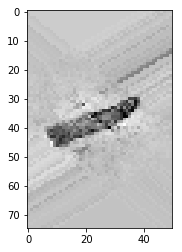

In [114]:
i = 1
plt.imshow(x_train[i][0], cmap='gray')

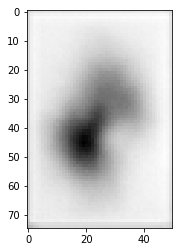

In [115]:
plt.imshow(x_train_decoded[i][0], cmap='gray')

### get a separate model (the encoder) that outputs latent features

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(inputs=x, outputs=z_mean)

In [91]:
encoder_wt = encoder.get_weights()

In [ ]:
encoder.save("../data/encoder_e60.h5")

### explore encoder result

- train

In [88]:
try:
    encoder
except:
    encoder = load_model("../data/encoder_e60.h5")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [132]:
start = datetime.now()
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

x_train_tsne = np.log(x_train_encoded) # code for when I set exactly 2 latent features
# tsne = TSNE(n_components = 2)
# start = datetime.now()
# x_train_tsne = tsne.fit_transform(x_train_encoded)
# end = datetime.now()
# runtime = (end - start).seconds / 60
# print("runtime", runtime, "minutes")

runtime 3.4833333333333334 minutes


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [133]:
print(x_train.shape, x_train_encoded.shape, x_train_tsne.shape)

(21888, 1, 75, 50) (21888, 8) (21888, 8)


In [94]:
# img=mpimg.imread(os.path.join(rootpath, "test", "070000_M17.png"))
# plt.imshow(img, cmap='gray')

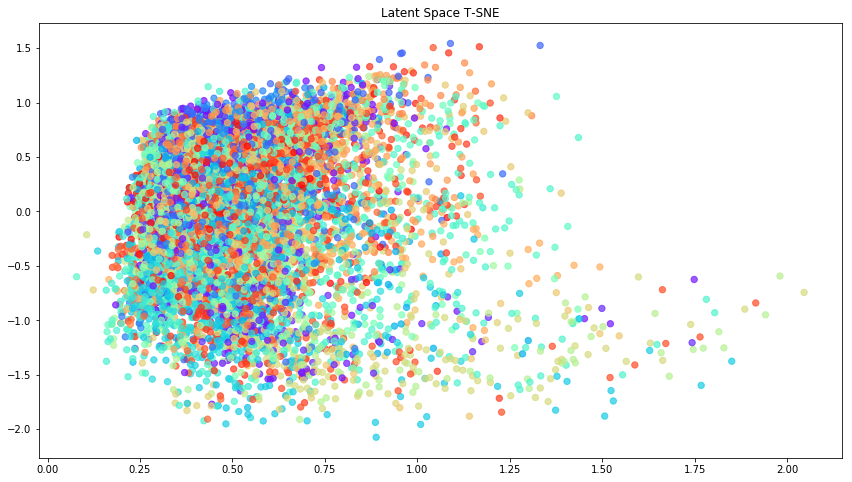

In [95]:
y_train_cat = pd.Series(np.argmax(y_train, 1), name = "true")
plt.figure(figsize = (18, 8))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_train_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_train_tsne[:, 0],
            x_train_tsne[:, 1],
            **kwargs)
plt.show()

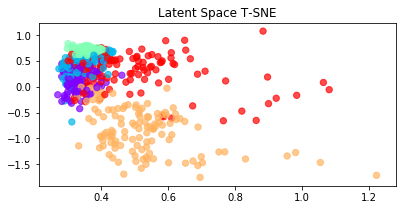

In [127]:
j = [1, 68, 144, 158, 169] # 0, 1, 51, 144, 158

y_train_cat = pd.Series(np.argmax(y_train, 1), name = "true")
plot_sample = (y_train_cat % n_classes).isin(j)
y_train_cat = y_train_cat[plot_sample]
plt.figure(figsize = (8, 3))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df.loc[plot_sample, "symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i % len(classes)] for i in range(len(y_train_cat))]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_train_tsne[plot_sample][:, 0],
            x_train_tsne[plot_sample][:, 1],
            **kwargs)
plt.show()

In [73]:
# TODO look at decoder results
# TODO look at encoder latent space itself

144

- test (more like a holdout since this is unsupervised learning)

In [48]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
tsne = TSNE(n_components = 2)
start = datetime.now()
x_test_tsne = tsne.fit_transform(x_test_encoded)
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

runtime 0.05 minutes


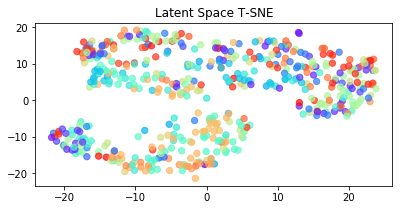

In [49]:
y_test_cat = pd.Series(np.argmax(y_test, 1), name = "true")
plt.figure(figsize = (8, 3))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_test_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_test_tsne[:, 0],
            x_test_tsne[:, 1],
            **kwargs)
plt.show()

### build classifier based on latent features

In [ ]:
# encoder = load_model("../data/encoder.h5")
# encoder_wt = encoder.get_weights()

In [74]:
try:
    del clf
except:
    pass
finally:
    clf = Sequential()
    n_encoder_layers = len(encoder.layers)
    for i in range(n_encoder_layers):
        clf.add(encoder.layers[i])
    clf.set_weights(encoder_wt) # loading encoder results as an initial value helps tremendously
    
    for layer in clf.layers:
        layer.trainable = True # loss doesn't go down when I'm freezing encoder layers 
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm1'))
    # clf.add(Dropout(0.5, name="clf_drop1"))
    clf.add(Dense(512, activation='tanh', kernel_initializer = myinitializer, name='clf1'))
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm2'))
    # clf.add(Dropout(0.2, name="clf_drop2"))
    clf.add(Dense(512, activation='tanh', kernel_initializer = myinitializer, name='clf2'))
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm3'))
    clf.add(Dropout(0.2, name="clf_drop3"))
    clf.add(Dense(n_classes, activation='softmax', name='predictions'))

In [75]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (16, 1, 75, 50)           0         
_________________________________________________________________
dropout_1 (Dropout)          (16, 1, 75, 50)           0         
_________________________________________________________________
conv1 (Conv2D)               (16, 8, 75, 50)           80        
_________________________________________________________________
conv2 (Conv2D)               (16, 64, 75, 50)          4672      
_________________________________________________________________
conv3 (Conv2D)               (16, 64, 75, 50)          36928     
_________________________________________________________________
conv4 (Conv2D)               (16, 128, 75, 50)         73856     
_________________________________________________________________
conv5 (Conv2D)               (16, 256, 75, 50)         295168    
__________

In [76]:
# compile model
# sgd = SGD(lr=clf_lr, decay=1e-6, momentum=0.9, nesterov=True) 
adm = Adam(lr=clf_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
clf.compile(optimizer=adm, loss='categorical_crossentropy')

### train classifier

In [77]:
clf_history_callback = clf.fit(x_train, y_train,
        shuffle=True, # False
        epochs=clf_epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

Train on 21888 samples, validate on 512 samples
Epoch 1/3
21888/21888 [==============================] - 894s - loss: 5.8522 - val_loss: 6.1677
Epoch 2/3
 4192/21888 [====>.........................] - ETA: 718s - loss: 5.7674

KeyboardInterrupt: 

In [78]:
plt.figure(figsize = (14, 4))
xaxis = range(clf_epochs)
plt.plot(xaxis, clf_history_callback.history['loss'], label = "train")
plt.plot(xaxis, clf_history_callback.history['val_loss'], label = "test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("classifier learning curve")
plt.legend()
plt.show()

NameError: name 'clf_history_callback' is not defined

In [ ]:
clf.save("../data/clf.h5")

In [ ]:
with open("../data/clf_hist.pkl", "wb") as picklefile:
    pickle.dump(clf_history_callback.history, picklefile)

### explore classifier performance

In [79]:
test_pred = clf.predict(x_test, batch_size=batch_size)

In [80]:
test_pred_cat = pd.Series(np.argmax(test_pred, 1), name = "pred")
y_test_cat = pd.Series(np.argmax(y_test, 1), name = "true")

In [81]:
accuracy = accuracy_score(y_test_cat, test_pred_cat)
misclassified = y_test_cat != test_pred_cat
n_misclassified = sum(misclassified)
print("accuracy", accuracy, "misclassified =", n_misclassified, "/", len(y_test_cat))
# for avg in ["micro", "macro"]:
#     accuracy = accuracy_score(y_test_cat, test_pred_cat)
#     precision = precision_score(y_test_cat, test_pred_cat, average = avg)
#     recall = recall_score(y_test_cat, test_pred_cat, average = avg)
#     f1 = f1_score(y_test_cat, test_pred_cat, average = avg)
#     print(avg, "average: accuracy", format(accuracy, "6.4f"), \
#           "precision", format(precision, "6.4f"), \
#           "recall", format(recall, "6.4f"), \
#           "f1", format(f1, "6.4f"))

accuracy 0.001953125 misclassified = 511 / 512


In [ ]:
pd.crosstab(test_pred_cat, y_test_cat)

In [ ]:
# TODO try:
# diff init values? He initializer (https://www.quora.com/What-is-are-the-method-s-for-initiating-choosing-filters-in-Convolutional-Neural-Networks)
# add/delete conv/encoding/clf layers
# way to make conv/encoding better?
